Using the code in this notebook, we accessed, processed, and analyzed SEC forms through their API.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install sec-downloader langchain sentence-transformers qdrant-client unstructured[all-docs]

In [ ]:
from pathlib import Path
import requests, json

In [ ]:
def make_request(url, headers):
    response = requests.get(url, headers=headers)
    return response

In [ ]:
%cd /content/drive/MyDrive/Anyone_AI/Final_Project

/content/drive/MyDrive/Anyone_AI/Final_Project


## SEC downloads

In [ ]:
from sec_downloader import Downloader

dl = Downloader("Sèrdna_Sagrav", "Sagravsky@gmail.com")

In [ ]:
from sec_downloader.types import RequestedFilings

metadatas = dl.get_filing_metadatas(
    RequestedFilings(ticker_or_cik="0000718877",
                     form_type="10-K",
                     limit=4)
)

In [ ]:
metadatas

[FilingMetadata(accession_number='0001628280-23-004842', form_type='10-K', primary_doc_url='https://www.sec.gov/Archives/edgar/data/718877/000162828023004842/atvi-20221231.htm', items='', primary_doc_description='10-K', filing_date='2023-02-23', report_date='2022-12-31', cik='0000718877', company_name='Activision Blizzard, Inc.', tickers=[]),
 FilingMetadata(accession_number='0001628280-22-003992', form_type='10-K', primary_doc_url='https://www.sec.gov/Archives/edgar/data/718877/000162828022003992/atvi-20211231.htm', items='', primary_doc_description='10-K', filing_date='2022-02-25', report_date='2021-12-31', cik='0000718877', company_name='Activision Blizzard, Inc.', tickers=[]),
 FilingMetadata(accession_number='0001628280-21-002828', form_type='10-K', primary_doc_url='https://www.sec.gov/Archives/edgar/data/718877/000162828021002828/atvi-20201231.htm', items='', primary_doc_description='10-K', filing_date='2021-02-23', report_date='2020-12-31', cik='0000718877', company_name='Activi

In [ ]:
metadatas

[FilingMetadata(accession_number='0001193125-11-149963', form_type='S-1', primary_doc_url='https://www.sec.gov/Archives/edgar/data/1318605/000119312511149963/ds1.htm', items='', primary_doc_description='FORM S-1 REGISTRATION STATEMENT', filing_date='2011-05-25', report_date='', cik='0001318605', company_name='Tesla, Inc.', tickers=[Ticker(symbol='TSLA', exchange='Nasdaq')]),
 FilingMetadata(accession_number='0001193125-10-017054', form_type='S-1', primary_doc_url='https://www.sec.gov/Archives/edgar/data/1318605/000119312510017054/ds1.htm', items='', primary_doc_description='REGISTRATION STATEMENT ON FORM S-1', filing_date='2010-01-29', report_date='', cik='0001318605', company_name='Tesla, Inc.', tickers=[Ticker(symbol='TSLA', exchange='Nasdaq')])]

In [ ]:
metadatas

[FilingMetadata(accession_number='0001193125-12-034517', form_type='S-1', primary_doc_url='https://www.sec.gov/Archives/edgar/data/1326801/000119312512034517/d287954ds1.htm', items='', primary_doc_description='REGISTRATION STATEMENT ON FORM S-1', filing_date='2012-02-01', report_date='', cik='0001326801', company_name='Meta Platforms, Inc.', tickers=[Ticker(symbol='META', exchange='Nasdaq')])]

In [ ]:
metadatas[0].primary_doc_url

'https://www.sec.gov/Archives/edgar/data/1326801/000119312512034517/d287954ds1.htm'

In [ ]:
html = dl.download_filing(url="https://www.sec.gov/Archives/edgar/data/1318605/000095017023001409/tsla-20221231.htm").decode()

## Tickers in SEC

In [ ]:
response = make_request(url="https://www.sec.gov/files/company_tickers.json",
                        headers={'User-Agent': 'Andres_Vargas agvargasb@gmail.com'})

In [ ]:
companies_cik = json.loads(response.content)

In [ ]:
companies_cik['9']

{'cik_str': 1046179,
 'ticker': 'TSM',
 'title': 'TAIWAN SEMICONDUCTOR MANUFACTURING CO LTD'}

In [ ]:
top_7_tickers = []

for _ in range(7):
  top_7_tickers.append(companies_cik[str(_)]['ticker'])

In [ ]:
top_7_tickers

['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA']

## Tickers in the pdf dataset

In [ ]:
dirs = list(Path("Raw_Data").glob("*"))
companies = []

for dir in dirs:
  companies.append(str(dir)[9:])

In [ ]:
pdfs = list(Path(f"Raw_Data/hutchison-china-meditech-limited").glob("*"))

In [ ]:
pdfs

[PosixPath('Raw_Data/hutchison-china-meditech-limited/NASDAQ_HCM_2017.pdf'),
 PosixPath('Raw_Data/hutchison-china-meditech-limited/NASDAQ_HCM_2018.pdf'),
 PosixPath('Raw_Data/hutchison-china-meditech-limited/NASDAQ_HCM_2019.pdf'),
 PosixPath('Raw_Data/hutchison-china-meditech-limited/NASDAQ_HCM_2020.pdf'),
 PosixPath('Raw_Data/hutchison-china-meditech-limited/NASDAQ_HCM_2021.pdf')]

In [ ]:
str(pdfs[0]).split('_')[2]

'HCM'

In [ ]:
len(set(companies))

2429

In [ ]:
company_ids = []

for company in companies:
  pdfs = list(Path(f"Raw_Data/{company}").glob("*"))

  try:
    id = str(pdfs[0]).split('_')[2]
    # company_ids[id] = company
    company_ids.append([id, company])
  except:
    print(f"Raw_Data/{company} is empty or is a file.")

Raw_Data/.DS_Store is empty or is a file.


In [ ]:
len(company_ids)

2428

In [ ]:
len(set(company_ids))

2421

## Some tickers are repeated in the dataset of PDF files.

In [ ]:
import pandas as pd

company_ids_df = pd.DataFrame(company_ids).rename(columns={0:'id', 1:'company'})
company_ids_df.groupby('id').agg({'id':'count'}).rename(columns={'id':'count'}).sort_values(by='count', ascending=False).iloc[0:7].index

Index(['CHEF', 'CTIC', 'TTEC', 'WLDN', 'HCKT', 'INAP', 'CCNE'], dtype='object', name='id')

In [ ]:
company_ids_df.set_index('id').loc[['CHEF', 'CTIC', 'TTEC', 'WLDN', 'HCKT', 'INAP', 'CCNE']]

,company
id,
CHEF,chefs-wharehouse
CHEF,the-chefs-warehouse
CTIC,cti-biopharma-corp
CTIC,cti-biopharma
TTEC,teletech-holdings-inc
TTEC,ttec-holdings-inc
WLDN,wildan-group
WLDN,willdan-group-inc
HCKT,hackett-group-inc


## Filings for 7 companies

In [ ]:
try:
  company_ids_df.set_index('id').loc[top_7_tickers]
except KeyError as error:
  print(error)

"['GOOGL', 'META'] not in index"


In [ ]:
from sec_downloader import Downloader

dl = Downloader("Andres_Vargas", "agvargasb@gmail.com")

In [ ]:
from sec_downloader.types import RequestedFilings

def metadata_recent_filings(ticker, form_type, limit):

  metadatas = dl.get_filing_metadatas(RequestedFilings(ticker_or_cik=ticker,
                                                       form_type=form_type,
                                                       limit=limit)
  )
  return metadatas

## Extract info from html files

In [ ]:
%pwd

'/content/drive/MyDrive/Anyone_AI/Final_Project'

In [ ]:
from langchain_community.document_loaders import UnstructuredFileLoader
from langchain.schema import Document
# from langchain_community.embeddings.openai import OpenAIEmbeddings
import pandas as pd
import seaborn as sns

### Zoom Video Communications, Inc.

In [ ]:
loader = UnstructuredFileLoader("zm-20230131.html", mode="elements")
# mode="elements", strategy="fast"

In [ ]:
docs = loader.load()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
len(docs)

1307

In [ ]:
docs[87].page_content

'Zoom\n enables people to connect to others, share ideas, make plans, and build\n toward a future limited only by their imagination. Our frictionless \ncommunications and collaboration platform started with video as its \nfoundation, and we have set the standard for innovation ever since. That\n is why Zoom is an intuitive, scalable, and secure choice for large \nenterprises, small businesses, and individuals alike. We provide a \nunified communications and collaboration platform that delivers \nhappiness and fundamentally changes how people interact, connecting them\n through frictionless and secure meetings, phone, chat, content sharing \nand more. Our Developer Platform enables customers, developers, and \nservice providers to easily build apps and integrations on top of Zoom’s\n industry-leading video communications and collaboration platform, with \nopportunities for global discovery and distribution. Our virtual and \nhybrid event solutions allow users to seamlessly create and ma

In [ ]:
docs[88].page_content

'Our\n cloud-native platform delivers reliable, high-quality video and voice \nsolutions that are easy to use, manage, and deploy; provides an \nattractive return on investment; and is scalable and easily integrates \nwith physical spaces and applications. As businesses around the world \nnavigate a period of significant work transformation, Zoom’s ability to \nenable meaningful connections whether teams are in the office, at home, \non-the-go, or in other locations such as a retail or manufacturing \nsetting, is a critical differentiator. We believe that rich and reliable\n communications lead to interactions that build greater empathy and \ntrust. We strive to live up to the trust our customers place in us by \ndelivering a communications solution that is secure, reliable, and “just\n works.”'

In [ ]:
docs[87].metadata

{'source': 'zm-20230131.html',
 'last_modified': '2023-12-26T08:26:54',
 'emphasized_text_contents': ['Zoom\n enables people to connect to others, share ideas, make plans, and build\n toward a future limited only by their imagination. Our frictionless \ncommunications and collaboration platform started with video as its \nfoundation, and we have set the standard for innovation ever since. That\n is why Zoom is an intuitive, scalable, and secure choice for large \nenterprises, small businesses, and individuals alike. We provide a \nunified communications and collaboration platform that delivers \nhappiness and fundamentally changes how people interact, connecting them\n through frictionless and secure meetings, phone, chat, content sharing \nand more. Our Developer Platform enables customers, developers, and \nservice providers to easily build apps and integrations on top of Zoom’s\n industry-leading video communications and collaboration platform, with \nopportunities for global discov

In [ ]:
docs[88].metadata

{'source': 'zm-20230131.html',
 'last_modified': '2023-12-26T08:26:54',
 'emphasized_text_contents': ['Our\n cloud-native platform delivers reliable, high-quality video and voice \nsolutions that are easy to use, manage, and deploy; provides an \nattractive return on investment; and is scalable and easily integrates \nwith physical spaces and applications. As businesses around the world \nnavigate a period of significant work transformation, Zoom’s ability to \nenable meaningful connections whether teams are in the office, at home, \non-the-go, or in other locations such as a retail or manufacturing \nsetting, is a critical differentiator. We believe that rich and reliable\n communications lead to interactions that build greater empathy and \ntrust. We strive to live up to the trust our customers place in us by \ndelivering a communications solution that is secure, reliable, and “just\n works.”'],
 'emphasized_text_tags': ['span'],
 'page_number': 7,
 'languages': ['eng'],
 'parent_id'

In [ ]:
docs_metadata = [{'page_content': doc.page_content,
                  'source': doc.metadata.get('source'),
                  'page_number': doc.metadata.get('page_number'),
                  'category': doc.metadata.get('category'),
                  'parent_id': doc.metadata.get('parent_id'),
                  } for doc in docs]

In [ ]:
docs_metadata_df = pd.DataFrame(docs_metadata)

In [ ]:
docs_metadata_df.columns

Index(['page_content', 'source', 'page_number', 'category', 'parent_id'], dtype='object')

In [ ]:
docs_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307 entries, 0 to 1306
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   page_content  1307 non-null   object
 1   source        1307 non-null   object
 2   page_number   1307 non-null   int64 
 3   category      1307 non-null   object
 4   parent_id     932 non-null    object
dtypes: int64(1), object(4)
memory usage: 51.2+ KB


In [ ]:
docs_metadata_df

,page_content,source,page_number,category,parent_id
0,Table of Contents,zm-20230131.html,1,Title,None
1,UNITED STATES,zm-20230131.html,1,Title,None
2,SECURITIES AND EXCHANGE COMMISSION,zm-20230131.html,1,Title,None
3,"Washington, D.C. 20549",zm-20230131.html,1,Title,None
4,______________________________________________...,zm-20230131.html,1,UncategorizedText,4463578c79ae29b009ca8f4756f8085f
...,...,...,...,...,...
1302,POWER OF ATTORNEY,zm-20230131.html,103,Title,None
1303,Each\n person whose signature appears below co...,zm-20230131.html,103,NarrativeText,9f2f6e626c71f2a101147e886f5aeb1d
1304,Pursuant\n to the requirements of the Securiti...,zm-20230131.html,103,NarrativeText,9f2f6e626c71f2a101147e886f5aeb1d
1305,Signature Title Date /s/ Eric S. Yuan Preside...,zm-20230131.html,103,Table,9f2f6e626c71f2a101147e886f5aeb1d


In [ ]:
docs_metadata_df['category'].value_counts()

NarrativeText        605
Title                374
ListItem             130
UncategorizedText    128
Table                 69
Address                1
Name: category, dtype: int64

In [ ]:
docs_metadata_df[docs_metadata_df['category'] == 'Table']

,page_content,source,page_number,category,parent_id
8,☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d...,zm-20230131.html,1,Table,d82367914f99171233c87bdd8d7c13ae
11,☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR ...,zm-20230131.html,1,Table,829e5b28af38ab3379fd0b4f3fd4f2f1
19,Delaware 61-1648780 (State or other jurisdicti...,zm-20230131.html,1,Table,bef57811e16cf9a3740929cb382417af
29,Title of each class Trading Symbol(s) Name of ...,zm-20230131.html,1,Table,289f35662b7cb724fbc4c9af124b0ee2
38,Large accelerated filer ☒ Accelerated filer ☐ ...,zm-20230131.html,1,Table,0c370fc54a9e9babb96ff5d66f19ba9d
...,...,...,...,...,...
1282,10.10# Confirmatory Offer Letter by and betwee...,zm-20230131.html,100,Table,a9360e0212a4d173581c91da68494d02
1285,101.PRE XBRL Taxonomy Extension Presentation L...,zm-20230131.html,101,Table,a9360e0212a4d173581c91da68494d02
1291,Balance at Beginning of Year Additions Write-...,zm-20230131.html,101,Table,4ad6087cfd613d23de5c10766469fcb2
1299,"ZOOM VIDEO COMMUNICATIONS, INC. Date: March 3...",zm-20230131.html,102,Table,642e510766e16f8a11cf440c0658d263


In [ ]:
docs_metadata_df[docs_metadata_df['category'] == 'UncategorizedText']

,page_content,source,page_number,category,parent_id
4,______________________________________________...,zm-20230131.html,1,UncategorizedText,4463578c79ae29b009ca8f4756f8085f
6,______________________________________________...,zm-20230131.html,1,UncategorizedText,26678be686452e6680cbc38a89def5b3
15,______________________________________________...,zm-20230131.html,1,UncategorizedText,b184d13173d27bc7e4d6b7c1e7345e15
18,______________________________________________...,zm-20230131.html,1,UncategorizedText,bef57811e16cf9a3740929cb382417af
25,(888) 799-9666,zm-20230131.html,1,UncategorizedText,289f35662b7cb724fbc4c9af124b0ee2
...,...,...,...,...,...
1280,98,zm-20230131.html,99,UncategorizedText,9e6825a29f60f70bee500eb3140510bb
1283,99,zm-20230131.html,100,UncategorizedText,a9360e0212a4d173581c91da68494d02
1295,100,zm-20230131.html,101,UncategorizedText,903ea500e7ccf842c1312b6c2f964e3e
1300,101,zm-20230131.html,102,UncategorizedText,642e510766e16f8a11cf440c0658d263


In [ ]:
docs_metadata_df[docs_metadata_df['category'] == 'Address']

,page_content,source,page_number,category,parent_id
23,"San Jose, California 95113",zm-20230131.html,1,Address,None


In [ ]:
docs_metadata_df[docs_metadata_df['category'] == 'Title']

,page_content,source,page_number,category,parent_id
0,Table of Contents,zm-20230131.html,1,Title,None
1,UNITED STATES,zm-20230131.html,1,Title,None
2,SECURITIES AND EXCHANGE COMMISSION,zm-20230131.html,1,Title,None
3,"Washington, D.C. 20549",zm-20230131.html,1,Title,None
5,FORM 10-K,zm-20230131.html,1,Title,None
...,...,...,...,...,...
1294,None.,zm-20230131.html,101,Title,None
1296,Table of Contents,zm-20230131.html,102,Title,None
1297,SIGNATURES,zm-20230131.html,102,Title,None
1301,Table of Contents,zm-20230131.html,103,Title,None


In [ ]:
docs_metadata_df[docs_metadata_df['category'] == 'ListItem']

,page_content,source,page_number,category,parent_id
62,Our\n business depends on our ability to attra...,zm-20230131.html,5,ListItem,f74fb678c4b3bfad8b80c2a8019d0a1b
63,Our revenue growth rate has fluctuated in prio...,zm-20230131.html,5,ListItem,f74fb678c4b3bfad8b80c2a8019d0a1b
64,"Interruptions,\n delays, or outages in service...",zm-20230131.html,5,ListItem,f74fb678c4b3bfad8b80c2a8019d0a1b
65,"We\n operate in competitive markets, and we mu...",zm-20230131.html,5,ListItem,f74fb678c4b3bfad8b80c2a8019d0a1b
66,Our\n business may be significantly affected b...,zm-20230131.html,5,ListItem,f74fb678c4b3bfad8b80c2a8019d0a1b
...,...,...,...,...,...
1246,certain\n representations with respect to a pr...,zm-20230131.html,98,ListItem,a9360e0212a4d173581c91da68494d02
1247,additional\n background information and disclo...,zm-20230131.html,98,ListItem,a9360e0212a4d173581c91da68494d02
1248,that\n whenever a document or information must...,zm-20230131.html,98,ListItem,a9360e0212a4d173581c91da68494d02
1249,require\n that any stockholder directly or ind...,zm-20230131.html,98,ListItem,a9360e0212a4d173581c91da68494d02


In [ ]:
docs_metadata_df[docs_metadata_df['category'] == 'NarrativeText']

,page_content,source,page_number,category,parent_id
9,"For the fiscal year ended January 31, 2023",zm-20230131.html,1,NarrativeText,d82367914f99171233c87bdd8d7c13ae
17,(Exact name of registrant as specified in its ...,zm-20230131.html,1,NarrativeText,bef57811e16cf9a3740929cb382417af
26,"(Registrant’s telephone number, including area...",zm-20230131.html,1,NarrativeText,289f35662b7cb724fbc4c9af124b0ee2
28,Securities registered pursuant to Section 12(b...,zm-20230131.html,1,NarrativeText,289f35662b7cb724fbc4c9af124b0ee2
30,Securities registered pursuant to section 12(g...,zm-20230131.html,1,NarrativeText,289f35662b7cb724fbc4c9af124b0ee2
...,...,...,...,...,...
1290,The\n table below details the activity of the ...,zm-20230131.html,101,NarrativeText,4ad6087cfd613d23de5c10766469fcb2
1292,All\n other financial statement schedules have...,zm-20230131.html,101,NarrativeText,4ad6087cfd613d23de5c10766469fcb2
1298,Pursuant\n to the requirements of the Securiti...,zm-20230131.html,102,NarrativeText,642e510766e16f8a11cf440c0658d263
1303,Each\n person whose signature appears below co...,zm-20230131.html,103,NarrativeText,9f2f6e626c71f2a101147e886f5aeb1d


In [ ]:
docs_metadata_df = docs_metadata_df[(docs_metadata_df['category'] == 'NarrativeText') | (docs_metadata_df['category'] == 'ListItem')]

In [ ]:
docs_metadata_df['length'] = docs_metadata_df['page_content'].map(lambda s: len(s))

In [ ]:
docs_metadata_df

,page_content,source,page_number,category,parent_id,length
9,"For the fiscal year ended January 31, 2023",zm-20230131.html,1,NarrativeText,d82367914f99171233c87bdd8d7c13ae,42
17,(Exact name of registrant as specified in its ...,zm-20230131.html,1,NarrativeText,bef57811e16cf9a3740929cb382417af,54
26,"(Registrant’s telephone number, including area...",zm-20230131.html,1,NarrativeText,289f35662b7cb724fbc4c9af124b0ee2,52
28,Securities registered pursuant to Section 12(b...,zm-20230131.html,1,NarrativeText,289f35662b7cb724fbc4c9af124b0ee2,59
30,Securities registered pursuant to section 12(g...,zm-20230131.html,1,NarrativeText,289f35662b7cb724fbc4c9af124b0ee2,64
...,...,...,...,...,...,...
1290,The\n table below details the activity of the ...,zm-20230131.html,101,NarrativeText,4ad6087cfd613d23de5c10766469fcb2,181
1292,All\n other financial statement schedules have...,zm-20230131.html,101,NarrativeText,4ad6087cfd613d23de5c10766469fcb2,326
1298,Pursuant\n to the requirements of the Securiti...,zm-20230131.html,102,NarrativeText,642e510766e16f8a11cf440c0658d263,187
1303,Each\n person whose signature appears below co...,zm-20230131.html,103,NarrativeText,9f2f6e626c71f2a101147e886f5aeb1d,1013


In [ ]:
lengths = docs_metadata_df.groupby(['page_number', 'parent_id']).agg({'length': 'sum'})['length']

In [ ]:
lengths.sort_values(ascending=True)

page_number  parent_id                       
49           688ae1ffe62779f7655849c22157ed7f      31
1            d82367914f99171233c87bdd8d7c13ae      42
65           b68d50d499059324c0ed6b3c1e5f71a1      51
84           909f03255d39721a2831665b6e03eaca      52
1            bef57811e16cf9a3740929cb382417af      54
                                                 ... 
15           a9360e0212a4d173581c91da68494d02    6555
19           a9360e0212a4d173581c91da68494d02    6647
22           a9360e0212a4d173581c91da68494d02    6803
33           a9360e0212a4d173581c91da68494d02    6851
21           a9360e0212a4d173581c91da68494d02    6872
Name: length, Length: 259, dtype: int64

In [ ]:
docs_metadata_df[(docs_metadata_df['page_number'] == 22) & (docs_metadata_df['parent_id'] == 'a9360e0212a4d173581c91da68494d02')]

,page_content,source,page_number,category,parent_id,length
315,prevalent\n and severe and can lead to signifi...,zm-20230131.html,22,NarrativeText,a9360e0212a4d173581c91da68494d02,811
316,Future\n or past business transactions (such a...,zm-20230131.html,22,NarrativeText,a9360e0212a4d173581c91da68494d02,528
317,"In\n addition, our reliance on third-party ser...",zm-20230131.html,22,NarrativeText,a9360e0212a4d173581c91da68494d02,1492
318,Any\n of the previously identified or similar ...,zm-20230131.html,22,NarrativeText,a9360e0212a4d173581c91da68494d02,939
319,"If\n our security measures are compromised, ou...",zm-20230131.html,22,NarrativeText,a9360e0212a4d173581c91da68494d02,1128
320,"In\n addition, security researchers and other ...",zm-20230131.html,22,NarrativeText,a9360e0212a4d173581c91da68494d02,1905


<Axes: xlabel='Count', ylabel='length'>

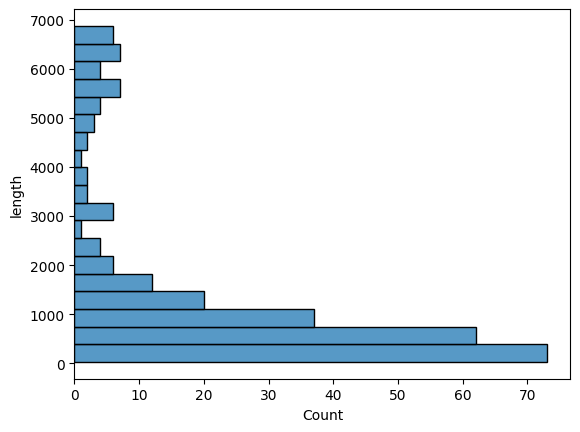

In [ ]:
sns.histplot(y=lengths)

### ACTIVISION BLIZZARD, INC

In [ ]:
loader = UnstructuredFileLoader("atvi-20221231.html", mode="elements")
# mode="elements", strategy="fast"

In [ ]:
docs_atvi = loader.load()

In [ ]:
len(docs_atvi)

1770

In [ ]:
docs_atvi_metadata = [{'page_content': doc.page_content,
                       'source': doc.metadata.get('source'),
                       'page_number': doc.metadata.get('page_number'),
                       'category': doc.metadata.get('category'),
                       'parent_id': doc.metadata.get('parent_id'),
                       } for doc in docs_atvi]

In [ ]:
docs_atvi_metadata_df = pd.DataFrame(docs_atvi_metadata)

In [ ]:
docs_atvi_metadata_df = docs_atvi_metadata_df[(docs_atvi_metadata_df['category'] == 'NarrativeText') | (docs_atvi_metadata_df['category'] == 'ListItem')]

In [ ]:
docs_atvi_metadata_df['length'] = docs_atvi_metadata_df['page_content'].map(lambda s: len(s))

In [ ]:
docs_atvi_metadata_df

,page_content,source,page_number,category,parent_id,length
11,(Exact name of registrant as specified in its ...,atvi-20221231.html,1,NarrativeText,b30c91fe8175bb47354d5e880753e61d,54
14,"(Registrant’s telephone number, including area...",atvi-20221231.html,1,NarrativeText,b30c91fe8175bb47354d5e880753e61d,52
15,Securities registered pursuant to Section 12(b...,atvi-20221231.html,1,NarrativeText,b30c91fe8175bb47354d5e880753e61d,59
17,Securities registered pursuant to Section 12(g...,atvi-20221231.html,1,NarrativeText,b30c91fe8175bb47354d5e880753e61d,59
19,Indicate by check mark if the registrant is a ...,atvi-20221231.html,1,NarrativeText,dc937b59892604f5a86ac96936cd7ff0,124
...,...,...,...,...,...,...
1756,"Management\n contract or compensatory plan, co...",atvi-20221231.html,121,ListItem,a9360e0212a4d173581c91da68494d02,137
1757,Portions of this exhibit omitted pursuant to I...,atvi-20221231.html,121,NarrativeText,a9360e0212a4d173581c91da68494d02,83
1761,Pursuant\n to the requirements of Section 13 o...,atvi-20221231.html,122,NarrativeText,642e510766e16f8a11cf440c0658d263,211
1766,Each\n individual whose signature appears belo...,atvi-20221231.html,122,NarrativeText,9f2f6e626c71f2a101147e886f5aeb1d,987


In [ ]:
lengths_atvi = docs_atvi_metadata_df.groupby(['page_number', 'parent_id']).agg({'length': 'sum'})['length']

In [ ]:
lengths_atvi.sort_values(ascending=True)

page_number  parent_id                       
53           f1a48669ba5ba5fe6071ea381f2500ed      14
52           1566ba6708e45225cf024f5893f61116      14
51           f1a48669ba5ba5fe6071ea381f2500ed      14
50           1566ba6708e45225cf024f5893f61116      14
4            ed880aaed2a10820ec6099c4dbc7ff2c      14
                                                 ... 
32           a9360e0212a4d173581c91da68494d02    5519
28           3d553d12f5fa75352a47238641c7a944    5577
26           a9360e0212a4d173581c91da68494d02    5703
23           a9360e0212a4d173581c91da68494d02    5768
30           a9360e0212a4d173581c91da68494d02    5795
Name: length, Length: 364, dtype: int64

<Axes: xlabel='Count', ylabel='length'>

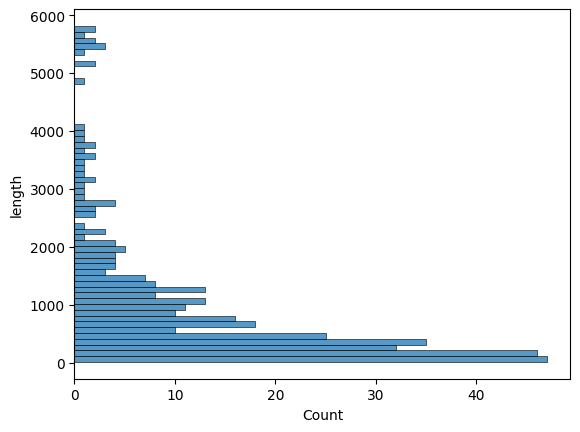

In [ ]:
sns.histplot(y=lengths_atvi, binwidth=100)

In [ ]:
print(lengths.mean(), lengths_atvi.mean())

1477.111969111969 962.2087912087912


In [ ]:
print(lengths.median(), lengths_atvi.median())

713.0 498.0
